In [1]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10683862559263759532
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2247832372
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5119633125556972629
physical_device_desc: "device: 0, name: NVIDIA T1200 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
class CellDataset(keras.utils.Sequence):
    def __init__(self, path, num_images, batch_size):
        self.path = path
        self.batch_size = batch_size
        self.num_images = num_images

    def __getitem__(self, idx):
        start = idx * self.batch_size
        images = []
        masks = []
        for i in range(start, start + self.batch_size):
            img_path = self.path + 'images/' + str(i) + '.jpg'
            mask_path = self.path + 'masks/' + str(i) + '.jpg'
            img = tf.keras.utils.img_to_array(load_img(img_path))[:,:,0]
            mask = tf.keras.utils.img_to_array(load_img(mask_path))[:,:,0] / 255
            images.append(img)
            masks.append(mask)
        
        images = np.stack(images)
        masks = np.stack(masks)

        return images, masks

    def __len__(self):
        return self.num_images // self.batch_size

(10, 520, 704) (10, 520, 704)


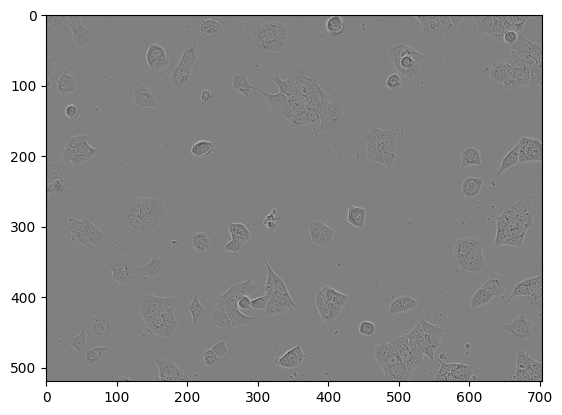

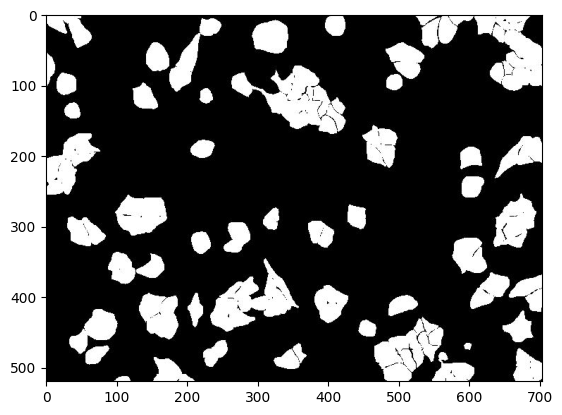

In [4]:
a = CellDataset("../generic_dataset/val/", 500, 10)

i, m = next(iter(a))
print(i.shape, m.shape)

from matplotlib import pyplot as plt
plt.imshow(i[7], cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(m[7]*255, cmap='gray', vmin=0, vmax=255)
plt.show()

In [5]:
from tensorflow.keras import layers

input_shape = (520, 704, 1)

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # encoded_patches = layers.Conv2D(2, 2, strides=2, padding="same")(inputs)
    # Augment data.
    # augmented = data_augmentation(inputs)
    # Create patches.
    # Create multiple layers of the Transformer block.
    encoded_patches = layers.Conv2D(2, 2, strides=2, padding="same", activation='relu')(inputs)
    encoded_patches = layers.Conv2D(2, 2, strides=2, padding="same", activation='relu')(encoded_patches)
    encoded_patches = layers.Conv2D(2, 2, strides=2, padding="same", activation='relu')(encoded_patches)
    encoded_patches = layers.Conv2D(2, 2, strides=2, padding="same", activation='relu')(encoded_patches)

    for _ in range(1):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=2, key_dim=2, dropout=0.1
        )(x1, x1)
        encoded_patches = attention_output
        # Skip connection 1.
        # x2 = layers.Add()([attention_output, encoded_patches])
        # # Layer normalization 2.
        # x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # # MLP.
        # # x3 = layers.Dense(2, activation=tf.nn.gelu)(x3)
        # x3 = layers.Dropout(0.1)(x3)
        # # Skip connection 2.
        # encoded_patches = layers.Add()([x3, x2])

    encoded_patches = layers.UpSampling2D(2)(encoded_patches)
    encoded_patches = layers.Conv2D(2, 4,padding="same", activation='relu')(encoded_patches)
    encoded_patches = layers.UpSampling2D(2)(encoded_patches)
    encoded_patches = layers.Conv2D(2, 4,padding="same", activation='relu')(encoded_patches)
    encoded_patches = layers.UpSampling2D(2)(encoded_patches)
    encoded_patches = layers.Conv2D(2, 4,padding="same", activation='relu')(encoded_patches)
    encoded_patches = layers.UpSampling2D(2)(encoded_patches)
    encoded_patches = tf.keras.layers.Resizing(520, 704, interpolation="bilinear", crop_to_aspect_ratio=False)(encoded_patches)
    # encoded_patches = layers.UpSampling2D(2)(encoded_patches)
    # encoded_patches = layers.UpSampling2D(2)(encoded_patches)
    outputs = layers.Conv2D(1, 4, padding="same", activation=tf.nn.sigmoid)(encoded_patches)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

keras.backend.clear_session()
model = create_vit_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 520, 704, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 260, 352, 2)  10          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 130, 176, 2)  18          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 65, 88, 2)    18          ['conv2d_1[0][0]']           

In [6]:
train_gen = CellDataset("../dataset/train/", 3253, 4)
val_gen = CellDataset("../dataset/train/", 570, 4)

model.compile(optimizer="rmsprop", loss="mean_squared_error")

callbacks = [
    keras.callbacks.ModelCheckpoint("nn_results", save_best_only=True)
]

epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
val_preds = model.predict(val_gen)

Epoch 1/5
813/813 [==============================] - ETA: 0s - loss: 0.1926

INFO:tensorflow:Assets written to: nn_results\assets


INFO:tensorflow:Assets written to: nn_results\assets


813/813 [==============================] - 64s 74ms/step - loss: 0.1926 - val_loss: 0.1429
Epoch 2/5
813/813 [==============================] - ETA: 0s - loss: 0.1387

INFO:tensorflow:Assets written to: nn_results\assets


INFO:tensorflow:Assets written to: nn_results\assets


813/813 [==============================] - 60s 74ms/step - loss: 0.1387 - val_loss: 0.1293
Epoch 3/5
813/813 [==============================] - ETA: 0s - loss: 0.1312

INFO:tensorflow:Assets written to: nn_results\assets


INFO:tensorflow:Assets written to: nn_results\assets


813/813 [==============================] - 61s 75ms/step - loss: 0.1312 - val_loss: 0.1220
Epoch 4/5
813/813 [==============================] - ETA: 0s - loss: 0.1273

INFO:tensorflow:Assets written to: nn_results\assets


INFO:tensorflow:Assets written to: nn_results\assets


813/813 [==============================] - 62s 76ms/step - loss: 0.1273 - val_loss: 0.1210
Epoch 5/5
813/813 [==============================] - ETA: 0s - loss: 0.1261

INFO:tensorflow:Assets written to: nn_results\assets


INFO:tensorflow:Assets written to: nn_results\assets


142/142 [==============================] - 8s 55ms/step


142/142 [==============================] - 7s 50ms/step


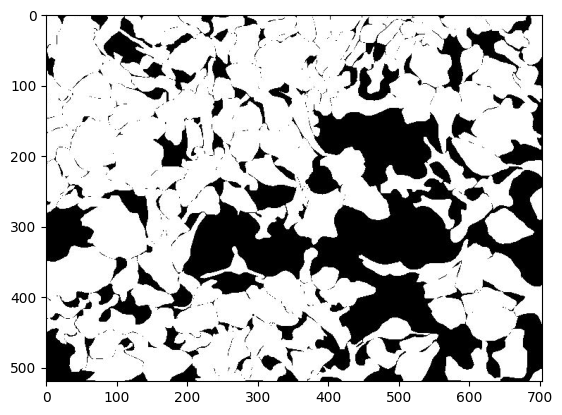

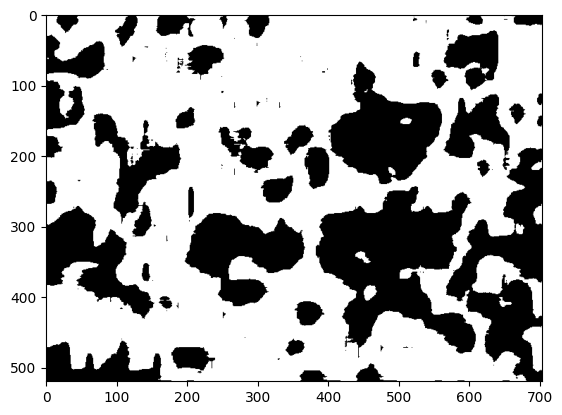

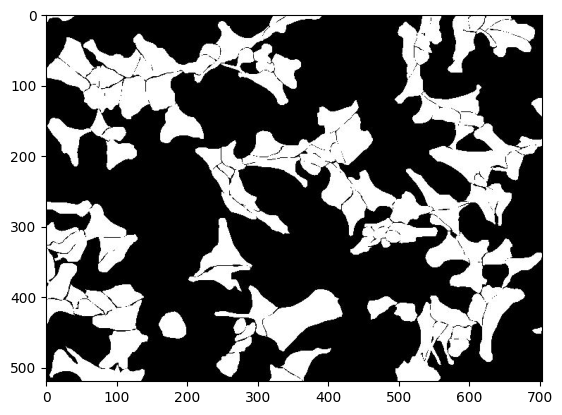

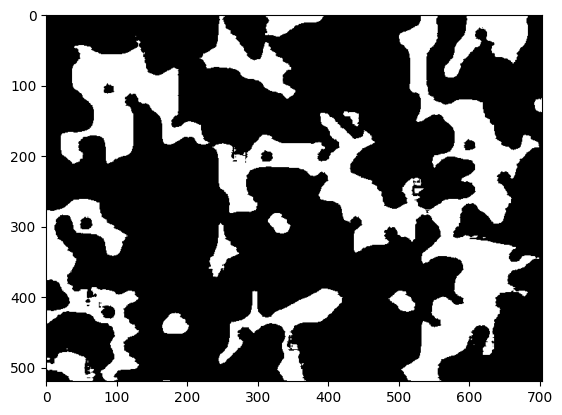

In [8]:
# print(val_preds.shape)

model = keras.models.load_model('nn_results')
val_preds = model.predict(val_gen)

input, actual = val_gen[0]
plt.imshow(actual[2]*255, cmap='gray', vmin=0, vmax=255)
plt.show()

temp = val_preds[2]
temp[temp >= 0.5] = 1
temp[temp < 0.5] = 0
example = (temp*255).astype('uint8')
plt.imshow(example, cmap='gray', vmin=0, vmax=255)
plt.show()

plt.imshow(actual[3]*255, cmap='gray', vmin=0, vmax=255)
plt.show()

temp = val_preds[3]
temp[temp >= 0.5] = 1
temp[temp < 0.5] = 0
example = (temp*255).astype('uint8')
plt.imshow(example, cmap='gray', vmin=0, vmax=255)
plt.show()



